In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import cm
from skimage.transform import resize

(2604, 4624, 3)


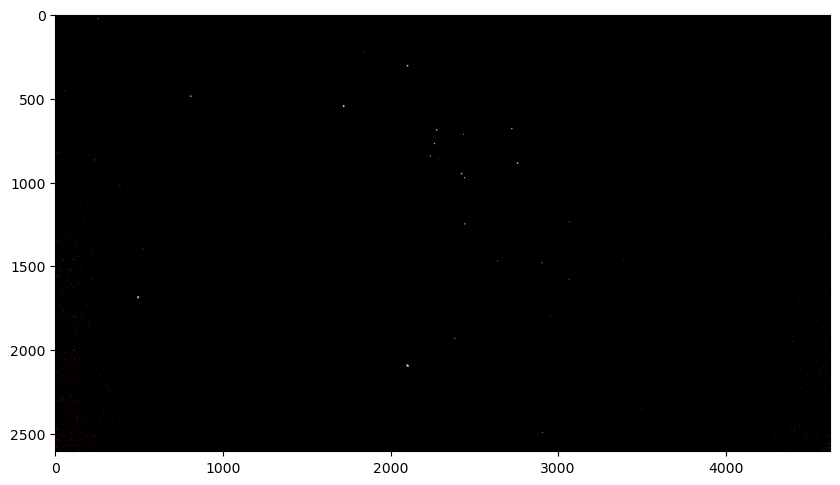

In [2]:
MIN_MATCH_COUNT = 10
th1 = 100
th2 = 20

size = (200,200)

img1 = cv.imread('Dataset/template matching data/orion_template.jpg')
img2 = cv.imread('Dataset/template matching data/orion_source_3.jpg')

img1 = np.where(img1 >= th1, 255, img1)
img1 = np.where(img1 < th1, 0, img1)

img2 = np.where(img2 >= th2, 255, img2)
img2 = np.where(img2 < th2, 0, img2)

# img1 = resize(img1, (img1.shape[0]/2, img1.shape[1]/2))

plt.figure(figsize=(10,10))
plt.imshow(img2, cmap='gray')
print(img1.shape)

In [3]:
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

In [4]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Not enough matches are found - 8/10


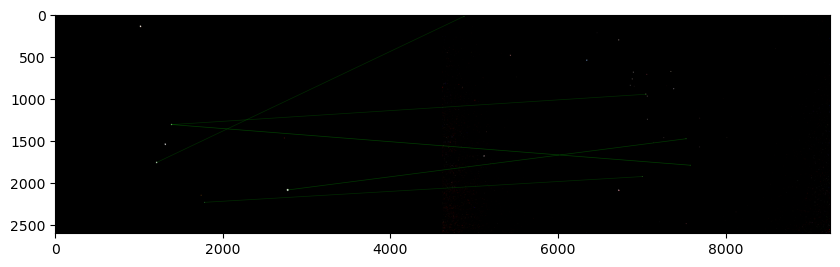

(<matplotlib.image.AxesImage at 0x7f7bd6c35c30>, None)

In [5]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(10,10))
plt.imshow(img3),plt.show()